<a href="https://colab.research.google.com/github/HyunJin-developer/OpenCv-python/blob/Hands-on/Hands_On_Chap3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chap 3, Classification, Hands on Machine Learning  



## 3.1 MNIST
 이 장에서는 고등학생과 미국 인구조사국 직원들이 손으로 쓴 7만 개의 작은 숫자 이미지를 모은 MNIST 데이터셋을 사용했다. 

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

이와 같이 사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.  

- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열을 담은 target 키
  
다음으로 위 배열들을 살펴본다.

In [ ]:
X, y = mnist['data'], mnist['target']   # data : 이미지, target : 레이블
print(X.shape, y.shape)

(70000, 784) (70000,)


데이터로는 이미지 파일을 사용한다. 따라서 7만개의 데이터와 784개의 특성이 있는데,이미지가 28 x 28 픽셀이기 때문에 784개의 특성이 있다. 

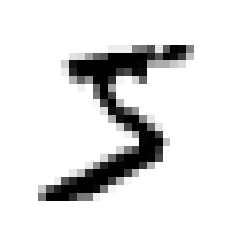

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")         # cmap(clror map)
plt.axis("off")
plt.show()

샘플의 특성 벡터를 추출해서 28 x 28 배열로 크기를 바꾸고 imshow() 함수를 사용해 그리면 된다. 위 코드의 결과는 숫자 5로 보이는데 실제 레이블을 확인해본다.

In [ ]:
y[0]

'5'

데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어 놓아야 한다. MNIST 데이터셋은 이미 훈련 세트(6만 개)와 테스트 세트(1만 개)로 나누어놨다.

In [ ]:
import numpy as np                        # 뒤에서 오류를 해결하기 위해 작성
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
y_train = y_train.astype(np.int8)       # 뒤에서 오류를 해결하기 위해 작성 y_train의 타입 변경

어떤 학습 알고리즘은 훈련 샘플의 순서에 민감해서 비슷한 샘플이 연이어 나타나면 성능이 나빠진다. 데이터셋을 섞으면 이런 문제를 방지할 수 있다.

## 3.2 이진 분류기 훈련
이진 분류기(binary classifier)란, 하나의 레이블만 식별하는 분류 작업이다. 그 예로 '5-감지기'라는 분류기로 숫자 5만 식별해본다.

In [ ]:
y_train_5 = (y_train == 5)        # 5는 True, 나머지 숫자는 모두 False
y_test_5 = (y_test == 5)

다음과 같이 타깃 벡터를 만들어 봤다면, 이제 분류 모델을 하나 선택해서 훈련해본다. 사이킷런의 SGDClassifier 클래스를 사용해서 확률적 경사 하강법(Stochastic Gradient Descent) 분류기를 먼저 사용해 본다.  
**SGD(Stochastic Gradient Descent)**
- 한 번에 하나씩 훈련 샘플을 독립적으로 처리(온라인 학습에 알맞음)
- 큰 데이터셋을 효율적으로 처리

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)        # random_state : 결과를 재현시키도록 초기값을 할당.(아무값이나 상관없음)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])       # some_digit : X[0]

array([ True])

SGD 분류기를 사용하여 다음과 같이 some_digit이 5가 맞는지 아닌지 확인해보았다. 다음과 같은 작업을 진행할 때 아래의 오류가 발생했었는데,  
**ValueError: The number of classes has to be greater than one; got 1 class**  

인터넷에 검색해 본 결과, np.astype을 해주어서 int8로 타입 변경을 해주면 해결 된다고 했다. 기존의 target 레이블은 스트링 '5' 라서 이런 문제가 발생한 듯 싶다.

## 3.3 성능 측정


### 3.3.1 교차 검증을 사용한 정확도 측정
2장에서 처럼 교차 검증은 모델을 평가하는 좋은 방법이다.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)      # n_splits=3 : 폴드를 3개로 분할, shuffle=True : 무작위로 섞음.

## 매 반복에서 분류기 객체를 복제하여 훈련 폴드로 훈련시키고, 테스트 폴드로 예측을 만듦.
## 전에 훈련데이터를 6만으로 잡았으므로, train 4만 test 2만으로 잡고 교차 검증 실행.
for train_index, test_index in skfolds.split(X_train, y_train_5):         # 3 개의 K폴드 이므로, 3쌍의 X_train, y_train_5를 반환
  clone_clf = clone(sgd_clf)              # 반복문마다 sgd 분류기 모델 복사
  X_train_folds = X_train[train_index]    # X_train 데이터 인덱싱
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)   # 모델 학습
  y_pred = clone_clf.predict(X_test_fold)       # 테스트 데이터(예측)
  n_correct = sum(y_pred == y_test_fold)        # 예측이 타깃과 맞은 경우
  print(n_correct / len(y_pred))                

0.9669
0.91625
0.96785


In [ ]:
# cross_val_score 사용
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")      #(모델명, 훈련 데이터, 타깃, cv)  

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
# 5-None 클래스로 분류하는 더미 분류기(Dummy classifier : 모든 이미지를 5가 아니라고 함.)

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)        # dtype=bool : 5가 아니면 True 맞으면 False를 반환 

never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

이미지의 10% 정도만 숫자 5이기 때문에 무조건 5가 아닌 것으로 예측해도 정확도는 90% 이상이다.   
**이 예제는 정확도를 분류기의 성능 측정 지표로 선호하지 않는 이유를 보여준다. 특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.**


### 3.3.2 오차행렬(Confusion Matrix)
앞 선 장에서 확인했듯이, 분류기의 성능 측정 지표로 정확도를 선호하지 않는다. 분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬을 조사하는 것이다. 기본적인 아이디어는 클래스 A의 샘플을 클래스 B로 분류되는 횟수를 세는 것이다.  
오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 먼저 예측값을 만들어야 한다.cross_val_predict() 함수를 사용해서 만들어 보자.

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)         # k-겹 교차 검증을 수행하지만, 평가 점수를 반환하지 않고, 각 테스트 폴드에서 얻은 예측을 반환.

이제 타깃 클래스와 예측 클래스를 넣고 호출하면 된다.

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

오차 행렬의 행은 실제클래스를 나타내고, 열은 예측한 클래스를 나타낸다. 첫 번째 행은 Negative class로, '5가 아님'을 53057개로 분류(True Negative)했고, 나머지 1522는 '5'라고 잘못 분류(False positive)했다. 두 번째 행은 Positive class로, 1325개를 '5가 아님'으로 잘못 분류(False negative)했고, 4096개를 정확히 '5'라고 분류(True positive)했다.   

오차 행렬 자체로도 많은 정보를 주지만, 더 요약된 지표가 필요할 때가 있다. 살펴볼만한 것이 양성 예측의 정확도이다. 이를 정밀도(precision)라고 한다.  
$정밀도 = \frac{TP}{TP+FP}$  
정밀도는 재현율(recall)이라는 또 다른 지표와 같이 사용하는 것이 일반적이다. 재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도(Sensitive) 또는 True Positive Rate(TPR)이라고도 한다.
$재현율 = \frac{TP}{TP+FN}$


### 3.3.3 정밀도와 재현율
앞 서 본 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 함수는 사이킷런에서 제공한다.

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))                  # == 3530 / (3530+697)
print(recall_score(y_train_5, y_train_pred))                     # == 3530 / (3530+1891)

0.8370879772350012
0.6511713705958311


정밀도와 재현율을 F1 score 라는 하나의 숫자로 만들면 특히 두 분류기를 비교할 때 편리하다. F1 score는 정밀도와 재현율의 조화 평균(harmonic mean)이다.  
$F1 = \frac{2}{\frac{1}{정밀도}+\frac{1}{재현율}} = 2\times\frac{정밀도\times재현율}{정밀도+재현율} = \frac{TP}{TP+\frac{FN+FP}{2}}$  



In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 score가 높다. 하지만 이게 항상 바람직한 것은 아니다. 상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있다. 불행히도 이 둘을 모두 얻을 수는 없다. 정밀도를 올리면 재현율이 줄고, 그 반대도 마찬가지다. 이를 **정밀도/재현율 트레이드오프**라고 한다. 

### 3.3.4 정밀도/재현율 트레이드오프
SGDClassifier가 분류를 어떻게 결정하는지 살펴보면서 트레이드 오프를 이해해본다. SGD는 결정함수(Decision function)을 사용하여 각 샘플의 점수를 계산한다. 



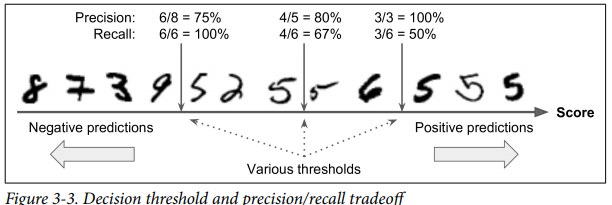

[그림 3-3]을 보면 이미지는 분류기가 만든 점수 순으로 나열되어 있다. 위를 보면 알 수 있듯이, 임계값을 오른 쪽으로 두면 둘 수록 정밀도는 올라가지만, 재현율은 떨어진다. 반대로 왼 쪽으로 둘 수록 정밀도는 내려가지만, 재현율은 올라간다.  

사이킷런에서 임계값을 직접 지정할 수는 없지만 예측에 사용한 점수는 확인할 수 있다. 분류기의 predict() 메서드 대신 decision_function() 메서드를 호출하면 된다. 

In [ ]:
y_score = sgd_clf.decision_function([some_digit])       #'5' 호출
print(y_score)                                          #some_digit의 점수
threshold = 0                                           #임계값
y_some_digit_pred = (y_score > threshold)
print(y_some_digit_pred)

[2164.22030239]
[ True]


In [ ]:
threshold = 8000
y_some_digit_pred = (y_score > threshold)
print(y_some_digit_pred)

[False]


적절한 임곗값을 정하려면 먼저 cross_val_predict()함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다. 

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")      # method를 decision_function으로 

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)         # precision_recall_curve로 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있음.

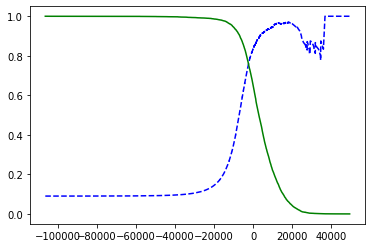

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, threshold):
  plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
  plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
  # 임계값 표시, 범례, 그리드, 축 이름

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

좋은 정밀도/재현율 트레이드오프를 선택하는 방법은 재현율에 대한 정밀도 곡선을 그리는 것이다. 위 결과와 같이 재현율 80% 근처에서 정밀도가 급격하게 줄어드는 것을 확인할 수 있다. 이 하강 직전을 트레이드오프로 선택하는 것이 좋다.  
정밀도 90%를 달성하는 것을 목표로 하고, 최소 정밀도가 90%가 되는 가장 낮은 임계값을 찾을 수 있다. 

In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]    #np.argmax()는 최댓값의 첫 번째 인덱스를 반환한다. 

이제 precision_score 메서드와 recall_score 메서드를 이용해서 확인해 본다.

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)          #y_score가 정밀도 90% 이상인 값

print(precision_score(y_train_5, y_train_pred_90))
print(recall_score(y_train_5, y_train_pred_90))

0.9000345901072293
0.4799852425751706


### 3.3.5 ROC 곡선
ROC 곡선은 Receiver Operating Characteristic Curve로 한글로는 수신기 조작 특성이라고 불린다. ROC 곡선은 거짓 양성 비율(False Positive Rate, FPR)에 대한 진짜 양성 비율(True Positive Rate, TPR)의 곡선이다. 말 그대로 거짓 양성 비율은 잘못 분류된 음성 샘플의 비율이고, 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(True Negative Rate, TNR)을 뺀 값이다.  
- TNR을 특이도(specificity)라고도 함
- ROC 곡선은 민감도(재현율)에 대한 1-특이도 그래프임

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

먼저 위 처럼 roc_curve() 함수를 이용해 여러 임곗값에서 TPR과 FPR을 계산한다.

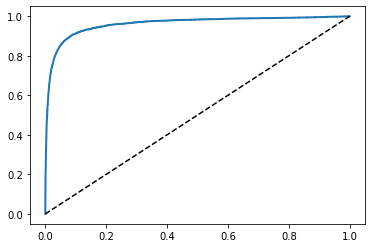

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1], [0,1], 'k--')     # 대각 점선

plot_roc_curve(fpr, tpr)
plt.show()

ROC curve에서도 트레이드오프가 있다. 재현율(TPR)이 높을수록 분류기가 만드는 거짓 양성(FPR)이 늘어난다. **점선은 완전한 랜덤 분류기의 ROC 곡선을 뜻한다.**   좋은 분류기는 이 점선에서 최대한 멀리 떨어져 있어야 한다. 여기서 **곡선 아래 면적(Area under the curve, AUC)을 측정하면 분류기들을 비교할 수 있다. ROC의 AUC가 1이랑 가까울 수록 완벽한 분류기이다. 사이킷런에서 ROC의 AUC를 계산하는 함수를 제공한다.

In [ ]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

RandomForestClassifier를 훈련시켜 SGDClassifier의 ROC 곡선과 ROC AUC 점수를 비교해보자. 먼저 훈련 세트의 샘플에 대한 점수를 얻어야 하지만, RandomForestClassifier에는 dicision_function()이 없다. 대신 predict_proba() 메서드가 있으므로 이를 사용한다.   
predict_proba()는 샘플이 행, 클래스가 열이고 샘플이 주어진 클래스에 속할 확률을 담은 배열을 반환한다. (예를 들어 어떤 이미지가 5일 확률 70%)

In [ ]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)          # 랜덤포레스트 객체
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")     # method : predict_proba

roc_curve() 함수는 레이블과 점수를 기대하지만, 점수 대신에 클래스 확률을 전달할 수 있다. 양성 클래스 확률을 점수로 사용해보자.

In [ ]:
y_probas_forest[:, :]       # 다음 코드에 사용할 probas_forest의 배열을 확인하기 위함 -> 첫 번째 열 음성 클래스 확률, 두 번째 열 양성 클래스 확률

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [ ]:
y_scores_forest = y_probas_forest[:, 1]         # 양성 클래스에 대한 확률을 점수로 사용한다.
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

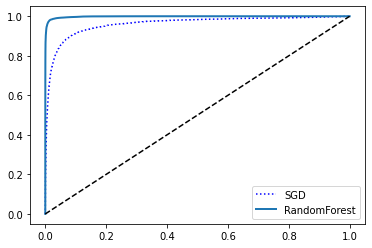

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")                   # 비교를 위해 SGD의 ROC 곡선도 같이 그림
plot_roc_curve(fpr_forest, tpr_forest, "RandomForest") # 랜덤포레스트의 ROC 곡선
plt.legend(loc="lower right")                           # 범례의 위치 설정
plt.show()

위의 결과와 같이 랜덤포레스트 분류기가 SGD 분류기보다 훨씬 좋아보인다. 당연하겠지만 AUC를 구해봐도 더 좋을 것이다. 

In [ ]:
print(roc_auc_score(y_train_5, y_scores_forest))

0.9983436731328145


## 3.4 다중 분류
이진 분류가 두 개의 클래스를 구별하는 반면 다중 분류기(Multiclass classifier)는 말 그대로 둘 이상의 클래스를 구별할 수 있다.  

 **하지만 이진 분류기를 여러 개 사용해 다중 클래스를 분류하는 기법도 많다.**

예를 들어 특징 숫자 하나만 구분하는 숫자별 이진 분류기를 10개 훈련 시켜, 클래스가 10개인 숫자 이미지 분류 시스템을 만들 수 있다. 
 - OvR(One-versus-the-Rest) or OvA(One-versus-All) : 이미지를 결정할 때 각 분류기의 결정 점수 중에서 가장 높은 것을 클래스로 선택 
 - OvO(One-versus-one) : 각 숫자의 조합마다 이진 분류기를 훈련(0과 1 구별, 0과 2 구별, 1과 2 구별)  

 
 OvO는 클래스가 N개라면 분류기는 $N\times(N-1)/2$개가 필요하다. 즉 MNIST 문제에서는 45개의 분류기를 훈련시켜야 한다. OvO의 장점은 각 분류기의 훈련 데이터 중 두 클래스에 해당하는 샘플만 필요하다는 것이다.   
일부 모델들은 훈련 데이터 크기에 민감하여 많은 데이터를 몇 개의 분류기로 훈련하는 것보다 적은 훈련 데이터를 많은 분류기로 훈련하는게 빠르므로 OvO를 선호한다. 하지만 대부분의 이진 분류 알고리즘에서는 OvR을 선호한다. 

In [ ]:
# 서포트백터머신 분류기 테스트
from sklearn.svm import SVC

svm_clf = SVC()
svm_clf.fit(X_train, y_train)     # y_train_5가 아니고, y_train을 사용한다.
svm_clf.predict([some_digit])     # X[0] 예측

array([5], dtype=int8)

위 처럼 다중 클래스 분류 작업에 이진 분류 알고리즘을 선택하면 사이킷런이 알고리즘에 따라 자동으로 OvR 또는 OvO를 실행한다. 내부에서 사이킷런이 OvO 전략을 사용해 45개의 이진 분류기를 훈련시키고 각가의 결정 점수를 얻어 점수가 가장 높은 클래스를 선택한다.

In [ ]:
some_digit_scores = svm_clf.decision_function([some_digit])       #decision_function을 이용해 결정 점수를 확인.
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

위 처럼 decision_functuin() 메서드를 호출하면 샘플 당 10개의 점수를 반환하고, 이 점수는 클래스마다 하나씩이다. 가장 높은 점수가 클래스 5에 해당하는 값이다. 

In [ ]:
print(np.argmax(some_digit_scores))
print(svm_clf.classes_)
print(svm_clf.classes_[5])    # 5번 째 인덱스

5
[0 1 2 3 4 5 6 7 8 9]
5


사이킷런에서 OvO나 OvR을 사용하도록 강제하려면 OneVsOneClassifier나 OneVsRestClassifier를 사용한다.

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
print(ovr_clf.predict([some_digit]))
len(ovr_clf.estimators_)          # estimator : 클래스 수 반환.

[9]


10

SGD 분류기나, 랜덤포레스트 분류기 또한 훈련시키는 것이 간단하다. 이런 경우 SGD 분류기는 직접 샘플을 다중 클래스로 분류할 수 있기 때문에 별도로 OvR이나 OvO를 적용할 필요가 없다. 

In [ ]:
sgd_clf.fit(X_train, y_train)       # SGDclassifier training   타깃을 각 10번 훈련
sgd_clf.predict([some_digit])

array([3], dtype=int8)

In [ ]:
sgd_clf.decision_function([some_digit])       # 클래스마다 부여한 점수 확인

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

이 결과에서 예측 결과에 강한 확신을 보이고 있음을 확인할 수 있다. 대 부분의 점수가 음수지만 클래스 5의 점수는 2412.5이기 때문이다.  
이제 분류기를 평가하기 위해 cross_val_score() 함수를 사용해보자.

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")    # SGD 모델 3번의 교차 검증

array([0.87365, 0.85835, 0.8689 ])

2장에서 본 스케일링을 통해 성능을 높일 수 있다. 

In [ ]:
from sklearn.preprocessing import StandardScaler            #  표준화 사이킷런 라이브러리 StandardScaler로 스케일 조정
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## 3.5 에러 분석
이렇게 해서 좋은 모델을 선정했을때 모델의 성능을 더 향상시키기 위해 에러의 종류를 분석한다. 먼저 오차 행렬, 즉  Confusion Matrix를 먼저 살펴 본다. 

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)      # 예측 값 생성
conf_mx = confusion_matrix(y_train, y_train_pred)           # 실제 타깃과 예측 값 비교
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

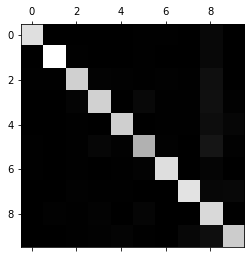

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)        # matplotlib의 함수 사용
plt.show()

위 결과를 보면 이미지가 올바르게 분류되었음을 나타내는 주대각선을 확인할 수 있는데, 매우 잘 분류된 것을 확인할 수 있다. 하지만 숫자 5는 다른 숫자보다 조금 더 어두워 보이는데, 이는 데이터셋에 숫자 5의 이미지가 적거나 잘 분류를 못했다는 뜻이므로, 두 경우에 대해 모두 확인해봐야 한다. 

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)       
norm_conf_mx = conf_mx / row_sums                   # 각 원소를 행별로 모두 더한 값으로 나눔.

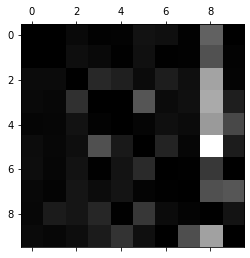

In [ ]:
np.fill_diagonal(norm_conf_mx, 0)                   # np.fill_diagonal() : 행렬의 대각원소를 입력 값으로 대체해주는 함수
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

여기서 우리는 많은 정보를 찾을 수 있다. 행은 실제 클래스를 나타내고, 열은 예측한 클래스를 나타내는 사실을 상기시키고 살펴보자.   
클래스 8의 열이 상당히 밝으므로 많은 이미지가 8로 잘못 분류되었음을 암시한다. 하지만 클래스 8의 행은 그리 나쁘지 않다. 여기서 볼 수 있듯이 오차 행렬은 반드시 대칭이 아니다. 3과 5가 서로 많이 혼동되고 있는 것도 확인할 수 있다. 





**위의 결과로 8로 잘못 분류되는 것을 줄이도록 개선할 필요가 있다. 예를 들어 8처럼 보이지만 실제로는 아닌 데이터를 더 훈련시키거나, 분류기에 도움 될 만한 특성을 더 찾아볼 수 있다. 예를 들어 동심원의 수(8은 2개, 6은 1개, 5는 0개)를 세거나, 어떤 패턴이 드러나도록(skikit-Image, Pillow, OpenCV) 이미지를 전처리해볼 수 있다.**

이런식으로 에러를 세밀하게 분석하면 분류기가 무슨 일을하고, 왜 잘못되었는지 통찰을 얻을 수 있지만, 더 어렵고 시간이 오래걸린다. 


In [ ]:
# 아래 코드에서 plot_digits is not defined 에러
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

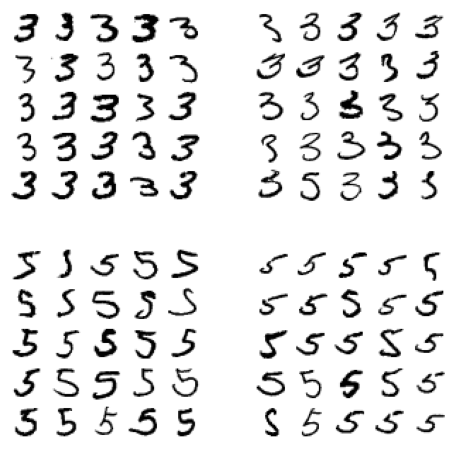

In [ ]:
import matplotlib

cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]        # 실제 타깃이 3이고, 예측 값도 3
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]        # 실제 타깃이 3이지만, 예측값은 5
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]        # 실제 타깃은 5이지만, 예측값은 3
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]        # 실제 타깃은 5이고, 예측 값도 5

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

2번 째, 3번 째 이미지가 잘 못 분류한 숫자이다. 몇몇은 정말 알아보기 힘든 숫자이기도 하지만, 대부분은 확실히 에러로 잘못 분류된 이미지처럼 보인다.  
**그 이유는 선형 모델인 SGDClassifier를 사용했기 때문이다. 선형 분류기는 픽셀에 가중치를 할당하고 새로운 이미지에 대해 단순히 픽셀 강도의 가중치 합을 클래스의 점수로 계산한다.(각 이미지의 가중치 점수 반환) 따라서 3과 5는 몇 개의 픽셀만 다르기 때문에 쉽게 혼동한다.**  
특히 이런 부분에서 분류기는 이미지의 위치나 회전 방향에 매우 민감하기 때문에 에러를 줄이는 한 가지 방법은 이미지를 중앙에 위치시키고, 회전되어 있지 않도록 전처리하는 것이다. 

## 3.6 다중 레이블 분류
지금 까지는 각 샘플이 하나의 클래스에만 할당되었다. 하지만 얼굴 인식 분류기에서 여러 사람의 tag를 붙여야 하는 등의 경우 때문에 다중 레이블 분류(Multilabel Classifier) 시스템은 중요하다. 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)          # 7,8,9 인 레이블 1
y_train_odd = (y_train % 2 ==1)         # 숫자가 홀수인 레이블 2
y_multilabel = np.c_[y_train_large, y_train_odd]      # 두개의 레이블을 넣은 다중 레이블 배열  np.c_ : 두개의 1차원 배열을 칼럼으로 붙여 2차원 배열 만듦.

knn_clf = KNeighborsClassifier()          # knn 분류기 객체 생성(다중 레이블 분류 지원)
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [ ]:
knn_clf.predict([some_digit])     # 5는 7보다 작지만, 홀수

array([[False,  True]])

다중 레이블 분류기를 평가하는 방법은 많지만, 적절한 지표는 프로젝트에 따라 다르다. 각 레이블의 F1 점수를 구하고 간단하게 평균 점수를 계산해본다.

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)      # knn의 예측값을 구함.
f1_score(y_multilabel, y_train_knn_pred, average="macro")                       # macro 평균 : 모든 레이블의 가중치가 같다고 생각. 
                                                                                # average="weighted" : 레이블에 속한 샘플 수로 가중치를 둚.

0.976410265560605

## 3.7 다중 출력 분류
 마지막으로 다중 레이블 분류에서 한 레이블이 다중 클래스가 될 수 있도록 일반화하는 것인 다중 출력 다중 클래스 분류(Multioutput-multiclass classification) 또는 간단히 다중 출력 분류(Multioutput classification)을 살펴본다.

노이즈가 많은 이미지를 입력으로 받아, 깨끗한 숫자 이미지를 MNIST 이미지 데이터 처럼 픽셀의 정도를 담은 배열로 출력해보자.

여기서 다중 출력의 의미는 노이즈 제거의 목적으로 한 픽셀당 한 레이블이 0~255이기 때문에 각 레이블은 여러개의 값을 가지게 되기 때문이다.



In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))        #numpy.random.randint(low, high=, size=(데이터셋크기, 28x28))
X_train_mod = X_train + noise                 # noise가 낀 X_train
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise                   # noise가 낀 X_test
y_train_mod = X_train                         # 타깃은 원본으로.
y_test_mod = X_test

some_index = 36000        
some_digit_noise = X_train_mod[some_index]            # 36000번 데이터셋(노이즈 있음)
some_digit_noise_img = some_digit_noise.reshape(28,28)
some_digit = X_train[some_index]                      # 노이즈 없는 데이터
some_digit_img = some_digit.reshape(28,28)

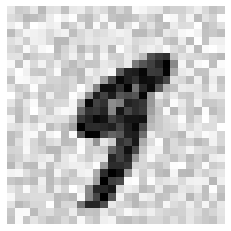

In [ ]:
plt.imshow(some_digit_noise_img, cmap=matplotlib.cm.binary)  #노이즈 낀 36000번 인덱스 데이터 출력, 흑백, 
plt.axis("off")     # matplotlib에 축 제거
plt.show()

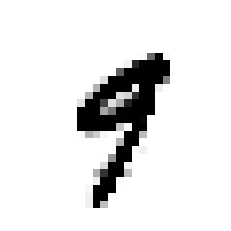

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)                       # 노이즈 낀 X_train과 원본 타깃을 훈련
clean_digit = knn_clf.predict([X_train_mod[some_index]])

plt.imshow(clean_digit.reshape(28,28), cmap=matplotlib.cm.binary)
plt.axis("off")
plt.show()